<a href="https://colab.research.google.com/github/hanadini/My-DataScience-Portfolio/blob/master/NLP_EDA_AmazonProductReviews11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math

In [5]:
from google.colab import files
files.upload()

Saving dataset.csv to dataset.csv


In [7]:
df=pd.read_csv("dataset.csv")
print("shape of data: ", df.shape)

shape of data:  (34660, 21)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


only needed information such as:
 product name, review text, user recommendation (binary), and the number of people that found a review helpful. 

In [8]:
df=df[['name','reviews.text','reviews.doRecommend','reviews.numHelpful']]
print("Shape of data: ", df. shape)
df.head(5)

Shape of data:  (34660, 4)


,name,reviews.text,reviews.doRecommend,reviews.numHelpful
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,True,0.0
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,True,0.0
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,True,0.0
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,True,0.0
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,True,0.0


In [10]:
df.isnull().sum()

name                   6760
reviews.text              1
reviews.doRecommend     594
reviews.numHelpful      529
dtype: int64

In [11]:
df.dropna(inplace=True)
df.isnull().sum()

name                   0
reviews.text           0
reviews.doRecommend    0
reviews.numHelpful     0
dtype: int64

only considering those products that have at least 500 reviews.

In [12]:
df=df.groupby('name').filter(lambda x:len(x)>500).reset_index(drop=True)
print('Number of product: ', len(df['name'].unique()))

Number of product:  8


reviews.numHelpful’ contains floating-point numbers, which is not possible. Therefore, converting these columns into integers.

In [13]:
df['reviews.doRecommend']=df['reviews.doRecommend'].astype(int)
df['reviews.numHelpful']=df['reviews.numHelpful'].astype(int)

In [14]:
df['name'].unique()

array(['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
       'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta',
       'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,',
       'Echo (White),,,\r\nEcho (White),,,',
       'Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,'], dtype=object)

In [15]:
df['name']=df['name'].apply(lambda x: x.split(',,,')[0])

In [16]:
for index, text in enumerate(df['reviews.text'][35:40]):
  print('review %d:\n'% (index+1), text)

review 1:
 I love everything about this tablet! The imaging is sharp and clear. It's fast and light weight. Love it!
review 2:
 Overall a nice product for traveling purposes Value for money
review 3:
 My children love this table great quality of pictures, excellent camera
review 4:
 I bought 3 tablets and my family was not disappointed.
review 5:
 Great tablet fast screen good size never gives me problem


Expand contractions,
Lowercase the reviews,
Remove digits and words containing digits,
Remove punctuations.



In [17]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}


In [18]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [19]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [20]:
# Expanding Contractions in the reviews
df['reviews.text']=df['reviews.text'].apply(lambda x:expand_contractions(x))

In [21]:
df['cleaned']=df['reviews.text'].apply(lambda x: x.lower())

In [22]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [23]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [24]:
# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [25]:
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 i love everything about this tablet the imaging is sharp and clear it is fast and light weight love it
Review 2:
 overall a nice product for traveling purposes value for money
Review 3:
 my children love this table great quality of pictures excellent camera
Review 4:
 i bought tablets and my family was not disappointed
Review 5:
 great tablet fast screen good size never gives me problem


Preparing Text Data for EDA

Stopwords Removal,
Lemmatization,
Create Document Term Matrix.

In [26]:
import spacy

nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [27]:
# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [28]:
# group them according to the products
df_grouped=df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",product far disappoint child love use like abi...
Amazon Fire Tv,echo learn everyday use daily use place speake...
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,nice little set slow wish investigate little j...
Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,good value money hand work perfectly purchase ...
Echo (White),compete ipad high end android tablet easily ou...


In [31]:
# create a Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index

df_dtm.head(3)

,aa,aaa,aamazon,abandon,abattery,abc,abcmouse,abcmousecom,abcs,abd,ability,abilty,abit,abke,able,abnormal,abode,abook,abound,abount,abouti,aboutif,abroad,abruptly,absence,absofbe,absoluitely,absolute,absolutely,absolutly,absorb,abt,abundance,abundant,abuse,ac,academic,acc,acce,accedently,...,youe,yougo,youit,youkathleen,younameit,young,younger,youngest,youngin,youngster,yourbedmate,youreyesprobably,yous,youse,youshe,youso,youth,youtube,youtubeand,youtubegmail,youtubekid,youtubenetflix,youtubepandora,youversion,youwhat,yr,yrold,yrs,yup,zeepad,zeppelin,zero,zigbee,zinio,zip,zippy,zone,zoo,zoom,zwave
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",0,0,0,0,0,0,0,0,0,0,24,0,1,0,77,0,0,0,0,1,0,0,0,0,0,0,0,3,33,0,0,0,0,0,2,0,0,1,1,0,...,0,0,0,0,0,20,0,0,0,0,0,1,0,0,0,0,1,37,0,0,0,0,0,0,0,23,0,3,0,0,0,4,0,1,0,0,0,0,0,0
Amazon Fire Tv,0,1,1,0,0,0,0,0,0,0,37,0,0,0,121,0,0,0,0,0,0,0,0,1,1,0,0,1,49,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,0,0,0,1,0,2,0,0,0,0,56,0,0,0,131,1,0,1,1,0,0,0,0,0,0,0,0,1,69,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,15,0,0,0,2,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,10,0,5,0,0,0,4,0,0,0,0,2,0,2,0


In [32]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

In [33]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

In [34]:
# Transposing document term matrix
df_dtm=df_dtm.transpose()

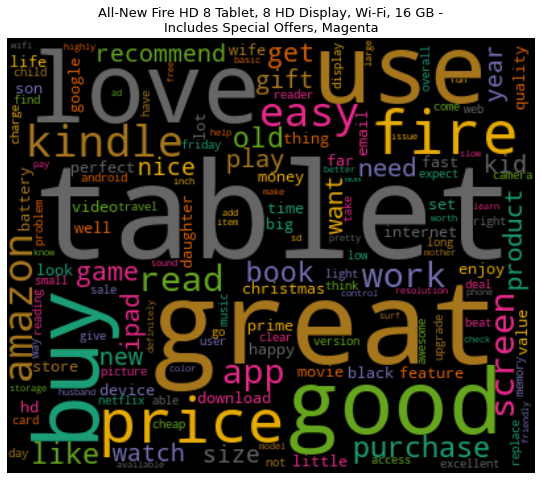

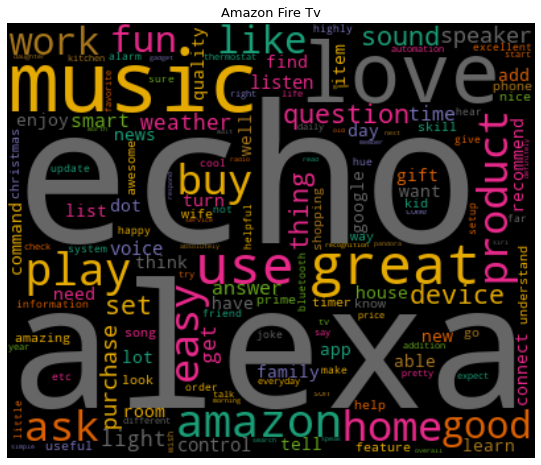

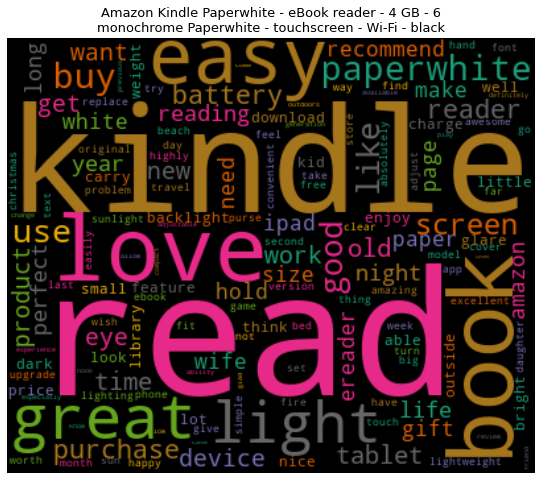

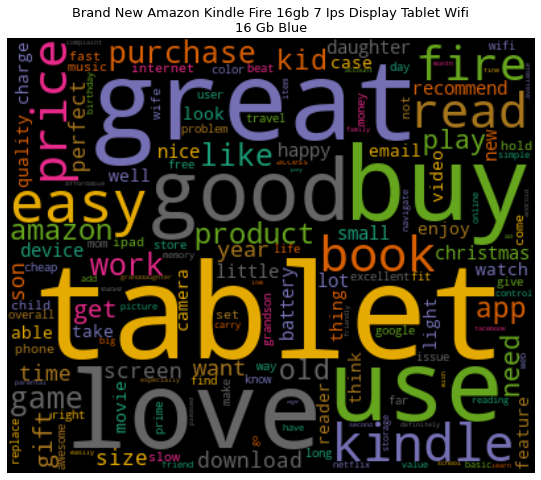

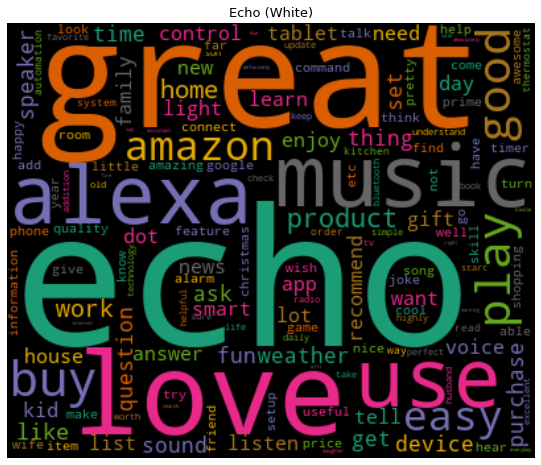

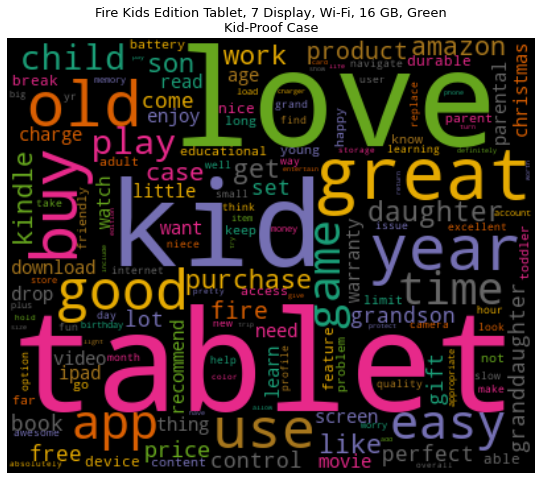

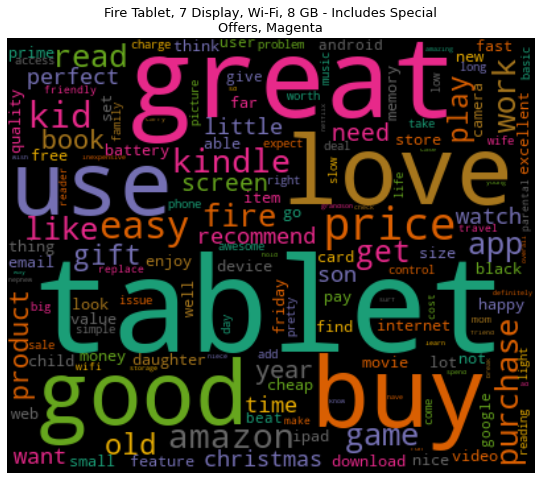

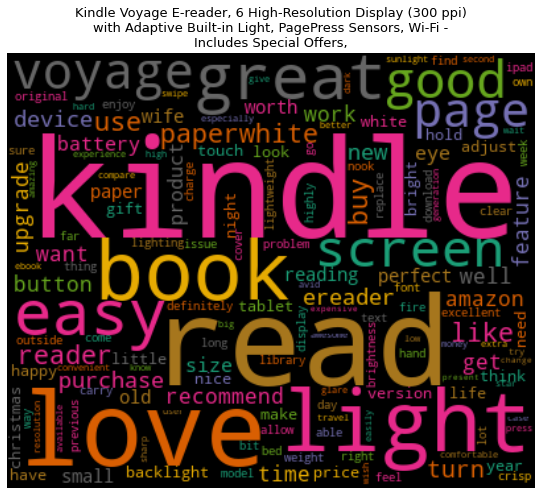

In [35]:
# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

In [36]:
#check the polarity of a review using the TextBlob library
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [37]:
# the most positive and negative reviews
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['reviews.text']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 This is an excellent product to give as a gift, one of the most reliable brands in the market.
Review 2:
 My Fire Kindle is wonderful and I use it all the time.
Review 3:
 Perfect for Home Automation and Wireless Entertainment.


In [38]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['reviews.text']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 Bought it so my son would stop grabbing for my phone. Does what it needs to but battery life is horrible
Review 2:
 Reason I would not give it a full five stars is because of the fact that is so loaded down with adware for Amazon but an awful lot of that is what makes it affordable so $49 cannot beat it
Review 3:
 I really like the Paperwhite, it made me want to read books on my Kindle again. Try it if you hate it, return it, but get your hands on this for a while, and I am convinced you will keep it.


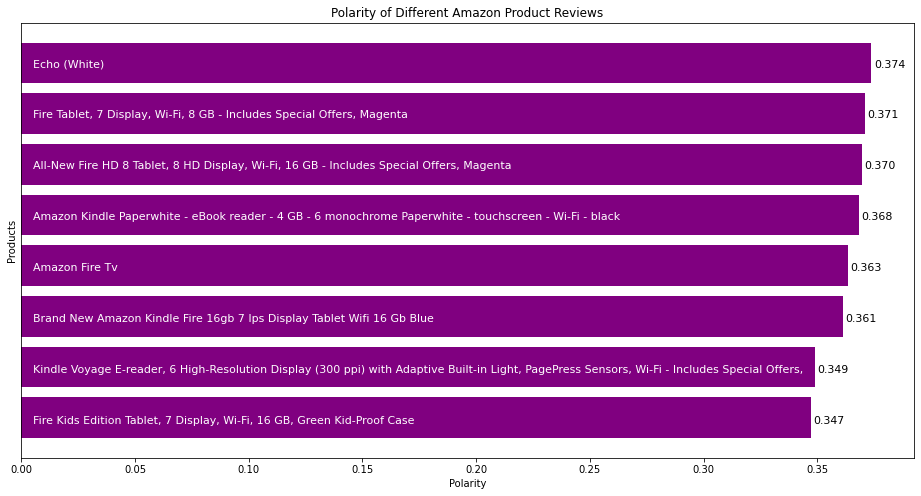

In [39]:
#plot polarities of reviews for each product and compare them
product_polarity_sorted=pd.DataFrame(df.groupby('name')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Products')
plt.title('Polarity of Different Amazon Product Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

Amazon needs to improve Fire Kids Edition Tablet and Kindle Voyage E-reader

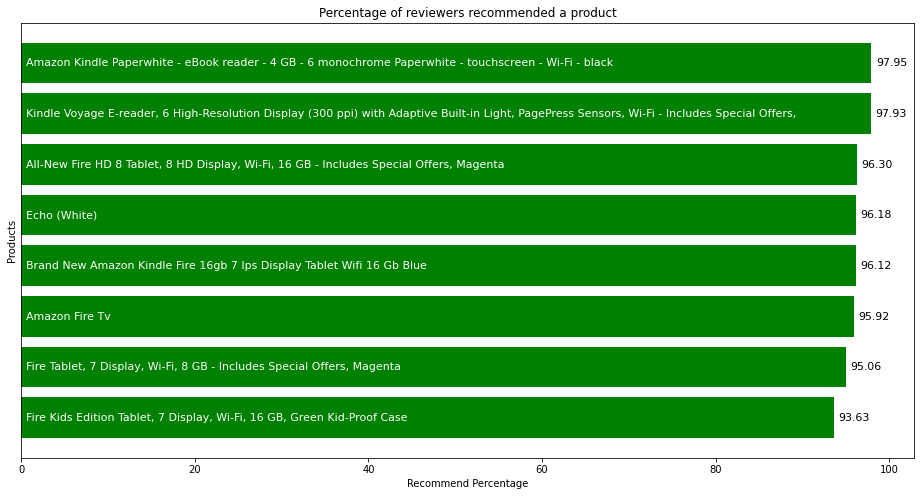

In [40]:
#he percentage of reviewers who recommended a particular product
recommend_percentage=pd.DataFrame(((df.groupby('name')['reviews.doRecommend'].sum()*100)/df.groupby('name')['reviews.doRecommend'].count()).sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Recommend Percentage')
plt.ylabel('Products')
plt.title('Percentage of reviewers recommended a product')
recommend_graph=plt.barh(np.arange(len(recommend_percentage.index)),recommend_percentage['reviews.doRecommend'],color='green')

# Writing product names on bar
for bar,product in zip(recommend_graph,recommend_percentage.index):
  plt.text(0.5,bar.get_y()+0.4,'{}'.format(product),va='center',fontsize=11,color='white')

# Writing recommendation percentage on graph
for bar,percentage in zip(recommend_graph,recommend_percentage['reviews.doRecommend']):
  plt.text(bar.get_width()+0.5,bar.get_y()+0.4,'%.2f'%percentage,va='center',fontsize=11,color='black')

plt.yticks([])
plt.show()

 Fire Kids Edition Tablet has the lowest recommendation percentage and the lowest polarity. So, the polarity of reviews affects the chances of a product getting recommended.

In [42]:
'''Textstat is typically used for determining readability, complexity, 
and grade level of a particular corpus'''
!pip install Textstat
import textstat

df['dale_chall_score']=df['reviews.text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_reading_ease']=df['reviews.text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['reviews.text'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of upvoted reviews=>',df[df['reviews.numHelpful']>1]['dale_chall_score'].mean())
print('Dale Chall Score of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['dale_chall_score'].mean())

print('Flesch Reading Score of upvoted reviews=>',df[df['reviews.numHelpful']>1]['flesh_reading_ease'].mean())
print('Flesch Reading Score of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['flesh_reading_ease'].mean())

print('Gunning Fog Index of upvoted reviews=>',df[df['reviews.numHelpful']>1]['gunning_fog'].mean())
print('Gunning Fog Index of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['gunning_fog'].mean())


     |████████████████████████████████| 101 kB 4.2 MB/s 
     |████████████████████████████████| 2.0 MB 15.2 MB/s 
Dale Chall Score of upvoted reviews=> 7.721178861788611
Dale Chall Score of not upvoted reviews=> 7.501252192632615
Flesch Reading Score of upvoted reviews=> 81.98257113821124
Flesch Reading Score of not upvoted reviews=> 84.8586581087524
Gunning Fog Index of upvoted reviews=> 7.980264227642276
Gunning Fog Index of not upvoted reviews=> 6.8617784244936715


There is very little difference in the Dale Chall Score and the Flesch Reading Score.

text_standard() function; that uses various readability checking formulas, combines the result and returns the grade of education required to understand a particular document completely.

In [44]:
df['text_standard']=df['reviews.text'].apply(lambda x: textstat.text_standard(x))

print('Text Standard of upvoted reviews=>',df[df['reviews.numHelpful']>1]['text_standard'].mode())
print('Text Standard of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['text_standard'].mode())

Text Standard of upvoted reviews=> 0    5th and 6th grade
dtype: object
Text Standard of not upvoted reviews=> 0    5th and 6th grade
dtype: object


Both upvoted and not upvoted reviews are easily understandable by anyone who has completed the 5th or 6th grade in school.

In [45]:
'''reading_time() function, which takes a piece of text as an argument and 
returns the reading time for it in seconds.'''

df['reading_time']=df['reviews.text'].apply(lambda x: textstat.reading_time(x))

print('Reading Time of upvoted reviews=>',df[df['reviews.numHelpful']>1]['reading_time'].mean())
print('Reading Time of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['reading_time'].mean())

Reading Time of upvoted reviews=> 3.4542174796747958
Reading Time of not upvoted reviews=> 1.7917397544251397


the reading time of upvoted reviews is twice that of not upvoted reviews. It means that people usually find longer reviews helpful.